In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import time

Some functions to show examples in the dataset.

In [2]:
def show1(data,type=tf.float64):
  #shows the first image in the dataset
  for e in data.take(1):
    print(e[0].shape)
    img = e[0]
    print(img[0][0])
    #print(e[1].shape)
    print(e[1])
    plt.imshow((tf.cast(e[0],dtype=type)))

In [3]:
def show5(data, type=tf.float64):
  #shows the first five images of the dataset
  fig, ax = plt.subplots(1,5)
  c=0
  for i in data.take(5):
      img = i[0]
      lbl = int(i[1])
      
      ax[c].imshow((tf.cast(img,dtype=type)), cmap='gray')
      ax[c].set_title(img.shape)
      #ax[c].set_title(lbl)
      ax[c].axis("off")

      c+=1

#1 Data set 
We will work with the Tensorﬂow Malaria dataset https://www.tensorflow.org/datasets/catalog/malaria. It contains 27.558 coloured images of cells with equal shares of
malaria-infected cells and uninfected cells.
1
Print out some of the images together with their shapes. Do you see a problem here?
Do you have an idea how to solve it?
2
Perform other necessary or beneﬁcial preprocessing steps.
3

# 1.1 load & split

In [4]:
training_ds, test_ds = tfds.load(
    name="Malaria",                       # name of the ds
    split=['train[:80%]','train[:-20%]'], # requested train-test-splits. This takes the first 100 000 of the training data and the first 1000 of the test-data
    as_supervised=True)                   # imports the labels as Tupels: (Input, Label)

**showing the problem**

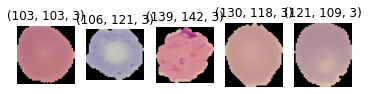

In [5]:
#this shows the first 5 pictures in training_ds. 
show5(training_ds, type=tf.int64)

Above the pictures we can see the shape they are in. As you can clearly see, the shape of the pictures varies. We need a uniform size for our Data. Therefore we chose the resize-function.

In [6]:
#Firstly we want to identify the average height and width of the pictures.
width=[]
height=[]

for (x,y) in training_ds:


  width+=[len(x)]
  height+=[len(x[0])]

averageheight=int(sum(height)/len(height))
averagewidth=int(sum(width)/len(width))

In [7]:
#using resize to generate a picture with same height and width
train_data = training_ds.map(lambda img, label: (tf.image.resize(img, [averageheight, averagewidth]),label)) 
test_data = test_ds.map(lambda img, label: (tf.image.resize(img, [averageheight, averagewidth]),label))

**showing the solved problem**

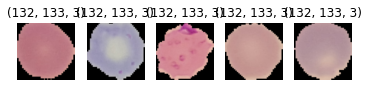

In [8]:
show5(train_data, type=tf.int64)


**Normalization & One-Hot-Encoding**

Here are some possible normalization-functions.

In [9]:
def normalize_0_1(x):
  #range 0 to 1
  #max = 255, min = 0
  max = tf.math.reduce_max(x)
  min = tf.math.reduce_min(x)
  result = tf.math.subtract(x, min)
  result = tf.math.divide(result,(max-min))
  return(result)

def normalize_neg_1(x):
  #range -1 to 1
  #max = 255, min = 0
  result = normalize_0_1(x)
  result = tf.math.multiply(result,2)
  result = tf.math.subtract(result,1)
  return(result)

def normalize_std(x):
  #range according gaussian standard distribution
  return tf.image.per_image_standardization(x)

We decided for the function *normalize_0_1*. But first lets have a look at the element, to see, how a normalization influences it.

(132, 133, 3)
tf.Tensor([0. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor(1, shape=(), dtype=int64)


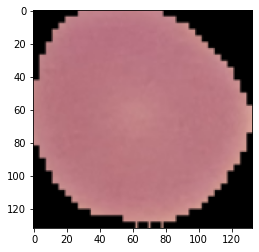

In [10]:
show1(train_data, type=tf.int64)

Now lets start the normalization process. Notice, that we also generate the **One-hot encoded** Labels!

In [11]:
#normalization range(0,1)
train_data = train_data.map(lambda img, label: (normalize_0_1(img),tf.one_hot(label, 2)))
test_data = test_data.map(lambda img, label: (normalize_0_1(img),tf.one_hot(label, 2)))


And lets look at the picture again:

(132, 133, 3)
tf.Tensor([0. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor([0. 1.], shape=(2,), dtype=float32)


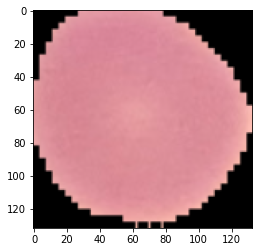

In [12]:
show1(train_data,tf.float64)

**Shuffling, Batching and Prefetching** <br>
In this step we shuffle the dataset, prepare mini-batches of size 64 and generate a prefetch dataset to learn from. We do this for the train and the test-datasets

In [13]:
train_data = train_data.shuffle(buffer_size=128)
train_data = train_data.batch(64)
train_data = train_data.prefetch(4)

test_data = test_data.shuffle(buffer_size= 128)
test_data = test_data.batch(64)
test_data = train_data.prefetch(4)

#2 Define CNN Model

Our Model is build out of 5 Convolutional Layers and Max-Pooling Layers in between. The amount of filters gets higher, the deeper we get into our network, since the amount of data that is being handled is getting more as well.

Structure:
1. Convolutional Layer with 16 Filters, Kernel_size 3 and relu activation
2. Maxpool
3. Convolutional Layer with 32 Filters, Kernel_size 3 and relu activation
4. Maxpool
5. Convolutional Layer with 64 Filters, Kernel_size 3 and relu activation
6. Maxpool
7. Convolutional Layer with 128 Filters, Kernel_size 3 and relu activation
6. Maxpool
7. Convolutional Layer with 264 Filters, Kernel_size 3 and relu activation
8. GlobalPool via Global average Pooling
9. HiddenLayer
10. Output-Layer

In [14]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class Model(Model): #generates a CNN with 5 Convolutional Layers and 

  def __init__(self): 
    super(Model, self).__init__()
    #Generating the different Layers in of their application.
    self.cov1 = tf.keras.layers.Conv2D(filters = 16,
                                       kernel_size = 3,
                                       strides = (1,1),
                                       padding = 'valid',
                                       activation = tf.keras.activations.relu,
                                       input_shape = (averageheight,averagewidth,3)  #as defined above, when we standarised the shape of the picture
                                       )
    self.maxpool1 = tf.keras.layers.MaxPool2D(pool_size= (2,2),
                                              strides = (2,2)
                                              )
    self.cov2 = tf.keras.layers.Conv2D(filters = 32,
                                       kernel_size = 3,
                                       strides = (1,1),
                                       padding = 'valid',
                                       activation = tf.keras.activations.relu
                                       )
    self.maxpool2 = tf.keras.layers.MaxPool2D(pool_size= (2,2),
                                              strides = (2,2)
                                              )
    self.cov3 = tf.keras.layers.Conv2D(filters = 64,
                                       kernel_size = 3,
                                       strides = (1,1),
                                       padding = 'valid',
                                       activation = tf.keras.activations.relu
                                       )
    self.maxpool3 = tf.keras.layers.MaxPool2D(pool_size= (2,2),
                                              strides = (2,2)
                                              )
    self.cov4 = tf.keras.layers.Conv2D(filters = 128,
                                       kernel_size = 3,
                                       strides = (1,1),
                                       padding = 'valid',
                                       activation = tf.keras.activations.relu
                                       )
    self.maxpool4 = tf.keras.layers.MaxPool2D(pool_size= (2,2),
                                              strides = (2,2))
    self.cov5 = tf.keras.layers.Conv2D(filters = 256,
                                       kernel_size = 3,
                                       strides = (1,1),
                                       padding = 'valid',
                                       activation = tf.keras.activations.relu
                                       )
    self.maxpool5 = tf.keras.layers.MaxPool2D(pool_size= (2,2),
                                              strides = (2,2))
    self.globalpool = tf.keras.layers.GlobalAveragePooling2D()
    self.hidden_layer = tf.keras.layers.Dense(units = 256,
                                              activation = tf.keras.activations.relu
                                              )
    self.output_layer = tf.keras.layers.Dense(units = 2,
                                        activation = tf.keras.activations.softmax
                                        )
  @tf.function
  def call(self, x):
    #The Layers feed into each other.
    x = self.cov1(x)
    x = self.maxpool1(x)
    x = self.cov2(x)
    x = self.maxpool2(x)
    x = self.cov3(x)
    x = self.maxpool3(x)
    x = self.cov4(x)
    x = self.maxpool4(x)
    x = self.cov5(x)
    x = self.maxpool5(x)
    x = self.globalpool(x)
    x = self.hidden_layer(x)
    x = self.output_layer(x)
    return x
    

#3. Training

**General Parameters** 

We define the important parameters of the Training here, so that they can be easily found and manipulated.

In [15]:
#General Parameters
trainforNepochs=19                                     
learning_rate=0.0008                                       
running_average_factor = 0.95                           
lossfunction= tf.keras.losses.BinaryCrossentropy()      #we use binary cross entropy as lossfunction
optimizer = tf.keras.optimizers.Adam(learning_rate)     #we use ADAM as optimizer

model = Model()                                         #As model we want to use the model from above


In [16]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape: #we safe the loss in the gradient tape 
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function):
  # test over complete test data
  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction).numpy()
    #print(sample_test_loss)
    sample_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss)
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [17]:
# Initialize lists for later visualization.
train_losses = []
test_losses = []
test_accuracies = []

#testing once before we begin, so that be have the first datapoints
test_loss, test_accuracy = test(model, test_data, lossfunction)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin, so that we have a baseline
train_loss, _ = test(model, train_data, lossfunction)
train_losses.append(train_loss)



Again we take a look how our model looks like. Isnt it a beauty?

In [18]:
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  73856 

Now lets finaly train this Model! We added some runtime approximation, so that you know how long this will take. It took us about 15 to twenty minutes.

In [19]:
# We train for trainforNepochs epochs.
for epoch in range(trainforNepochs):

    #just some fun runtime approximation that you can ignore :D
    if epoch == 0:              #before the first epoch we dont know how much time is going to pass.
      start = time.time()       #what we know is, when we started!
      time_remaining="Unknown"
    else:
      now = time.time()                                         
      time_per_epoch = ((now-start)/epoch)                      #average of the time per epoch
      remaining_epochs = trainforNepochs-epoch                  #numbers of remaining epochs
      time_remaining = round(time_per_epoch*remaining_epochs,0)
    print('Epoch:',str(epoch + 1 ),"of",str(trainforNepochs)+". Time remaining:", time_remaining, "seconds")





    #training (and checking in with training)
    running_average = 0
    for (input,target) in train_data:                           #Training the model as long as we have training data
        train_loss = train_step(model, input, target, lossfunction, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing how good the model performed in the current step
    test_loss, test_accuracy = test(model, test_data, lossfunction)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

now = time.time()

print("Finished after",round(now-start,0),"seconds.")

Epoch: 1 of 19. Time remaining: Unknown seconds
Epoch: 2 of 19. Time remaining: 826.0 seconds
Epoch: 3 of 19. Time remaining: 773.0 seconds
Epoch: 4 of 19. Time remaining: 728.0 seconds
Epoch: 5 of 19. Time remaining: 682.0 seconds
Epoch: 6 of 19. Time remaining: 636.0 seconds
Epoch: 7 of 19. Time remaining: 590.0 seconds
Epoch: 8 of 19. Time remaining: 544.0 seconds
Epoch: 9 of 19. Time remaining: 499.0 seconds
Epoch: 10 of 19. Time remaining: 453.0 seconds
Epoch: 11 of 19. Time remaining: 408.0 seconds
Epoch: 12 of 19. Time remaining: 362.0 seconds
Epoch: 13 of 19. Time remaining: 317.0 seconds
Epoch: 14 of 19. Time remaining: 271.0 seconds
Epoch: 15 of 19. Time remaining: 226.0 seconds
Epoch: 16 of 19. Time remaining: 181.0 seconds
Epoch: 17 of 19. Time remaining: 136.0 seconds
Epoch: 18 of 19. Time remaining: 90.0 seconds
Epoch: 19 of 19. Time remaining: 45.0 seconds
Finished after 858.0 seconds.


#Visualization
In this final step we generate some interesting graphics to see how well our classification process worked. 

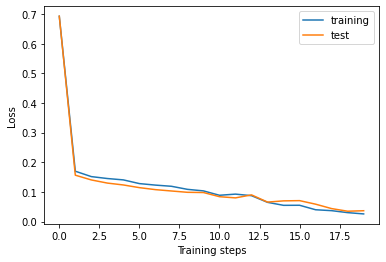

In [20]:
# One plot training and test loss.

plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

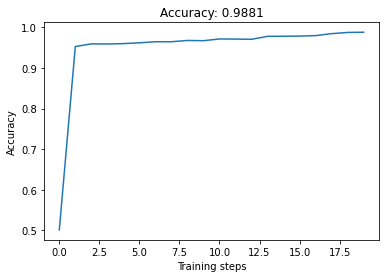

In [21]:
# One plot training and test accuracy.
plt.figure()
line1, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.title("Accuracy: " + str(np.round(np.max(test_accuracies),4)))
plt.show()

No visualization-task is complete without a pie-chart: Enjoy :D

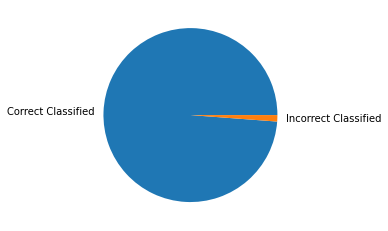

In [23]:
x = np.array([np.round(np.max(test_accuracies),4), 1-np.round(np.max(test_accuracies),4)])
label = ["Correct Classified", "Incorrect Classified"]

plt.pie(x, labels=label)
plt.show()